In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pymc3 as pm
import theano

In [2]:
elements = pd.read_csv('pd_data/elements_men.csv')
components = pd.read_csv('pd_data/components_summary_men.csv')
skaters = sorted(elements.skater.unique())
num_skaters = len(skaters)
skater_lookup = dict(zip(skaters, xrange(len(skaters))))

In [8]:
components['date'] = components.date.astype('datetime64')
cutoff_date = components[components.event == 'gpusa2015'].date.unique().astype('datetime64')[0]
components = components[components.date >= cutoff_date]

In [3]:
ELT_TYPES = ('ch', 'st', 'sp', '1j', '2j', '3j', '4j')
COMP_TYPES = ('ss', 'tr', 'pe', 'co', 'in')

In [4]:
results = {}  # dict of (trace, model, theano shared)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:06<00:00, 146.85it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:10<00:00, 94.96it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:31<00:00, 31.28it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:10<00:00, 95.68it/s]


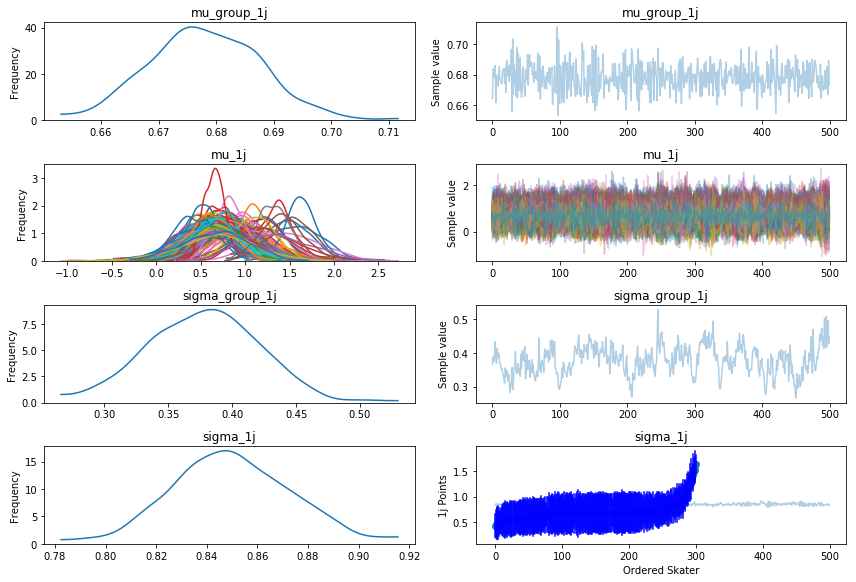

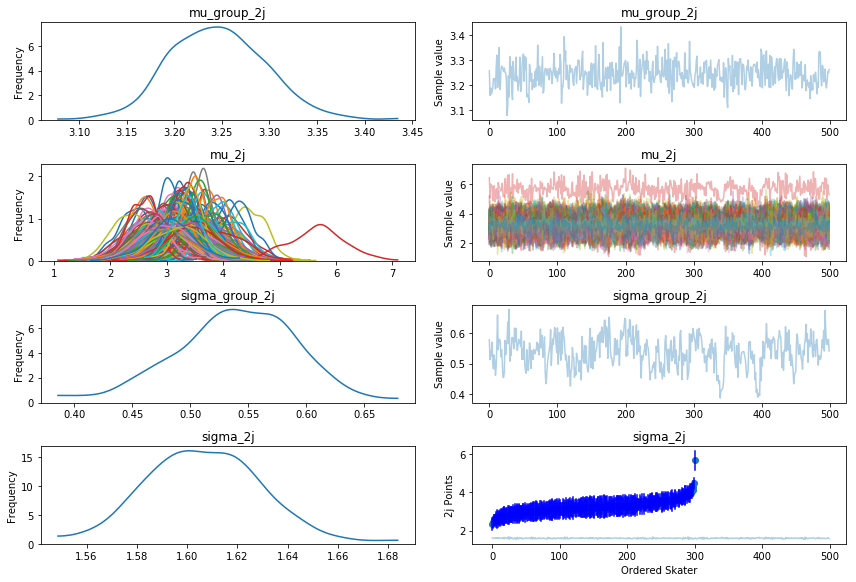

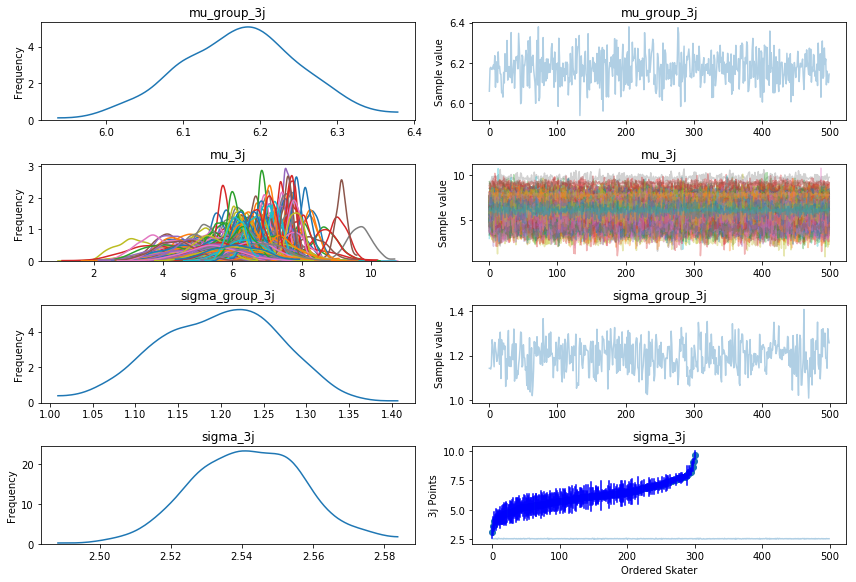

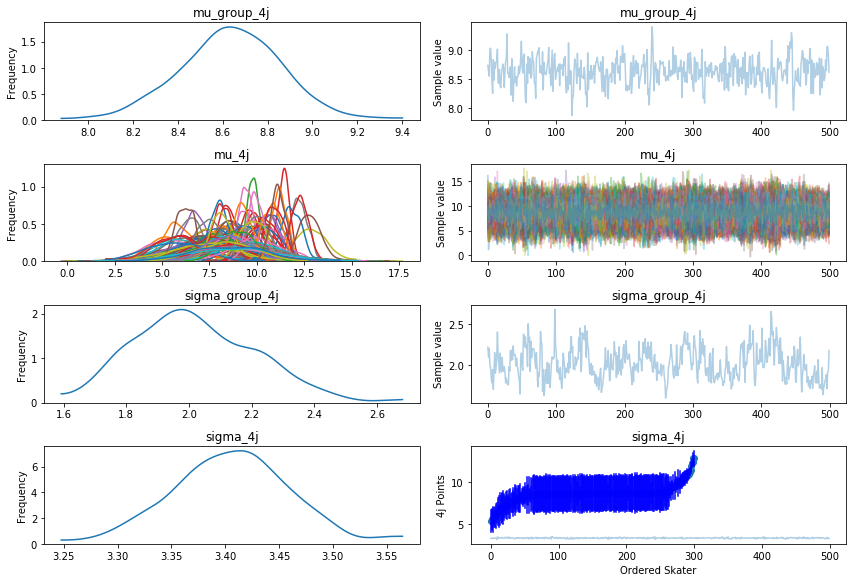

In [14]:
for elt_type, prior_mu, prior_sd in ( #('sp', 2.5, 0.5), ('ch', 2., 0.5), ('st', 3., 0.5), 
                                     ('1j', 0.67, 0.01), ('2j', 4., 0.5), ('3j', 6., 0.7), ('4j', 10.5, 1.0)):
    elts = elements[elements.elt_type == elt_type]
    skater = elts['skater_code'] = elts.skater.replace(skater_lookup).values
    skater = theano.shared(skater)
    points = elts.points
    
    model = pm.Model()
    with model:
        # Prior on group distribution.
        mu_g = pm.Normal('mu_group_' + elt_type, prior_mu, sd=prior_sd)
        sigma_g = pm.HalfCauchy('sigma_group_' + elt_type, 5)
        
        # Group distribution.
        mu = pm.Normal('mu_' + elt_type, mu=mu_g, sd=sigma_g, shape=num_skaters)
        sigma = pm.HalfCauchy('sigma_' + elt_type, 5)  # not used in 1j
        
        # Data model.
        y = pm.Normal('y_' + elt_type, mu[skater], sd=sigma, observed=points)

    # Fit the model.
    with model:
        trace = pm.sample()
        
    # Save the results.
    results[elt_type] = (trace, model, skater)
    
    # Visualize fit.
    pm.traceplot(trace)
    estimates = pd.Series(trace['mu_' + elt_type].mean(axis=0), index=skaters)
    se = pd.Series(trace['mu_' + elt_type].std(axis=0), index=skaters)
    order = estimates.sort_values().index
    plt.scatter(xrange(len(estimates)), estimates[order])
    for i, m, s in zip(range(len(estimates)), estimates[order], se[order]):
        plt.plot([i,i], [m-s, m+s], 'b-')
    plt.ylabel(elt_type + ' Points');plt.xlabel('Ordered Skater');

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:16<00:00, 59.28it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:14<00:00, 69.77it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:08<00:00, 113.10it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:11<00:00, 88.73it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:10<00:00, 96.29it/

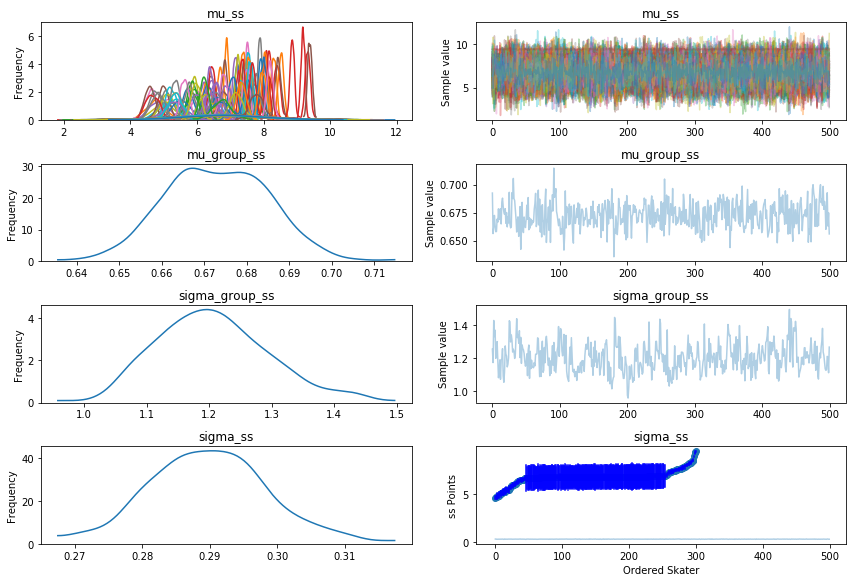

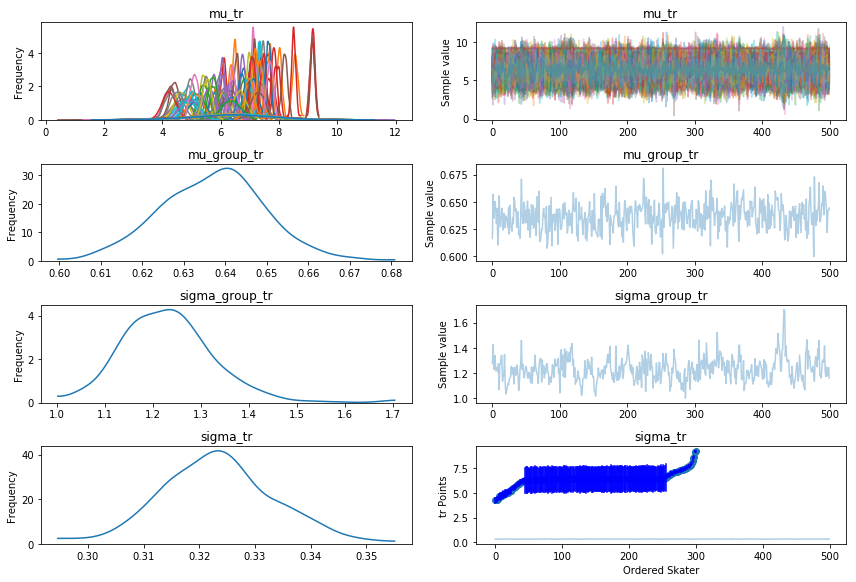

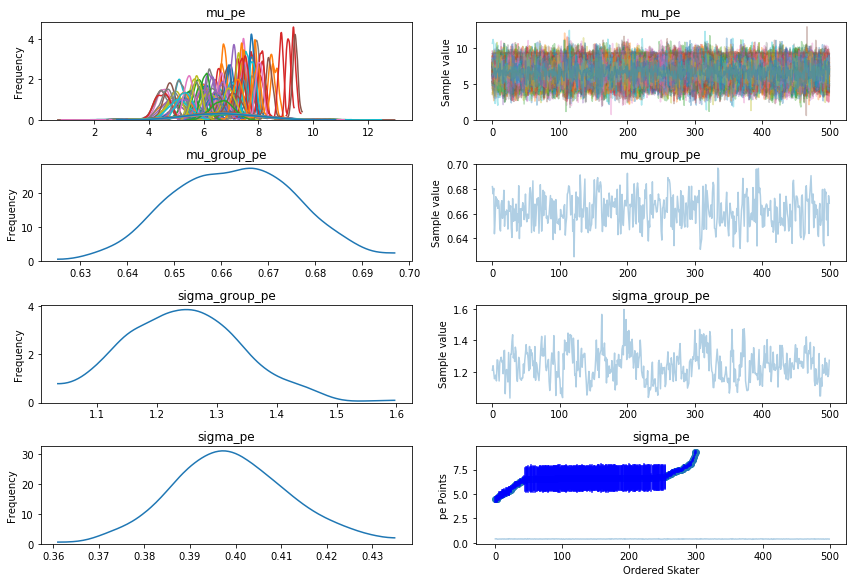

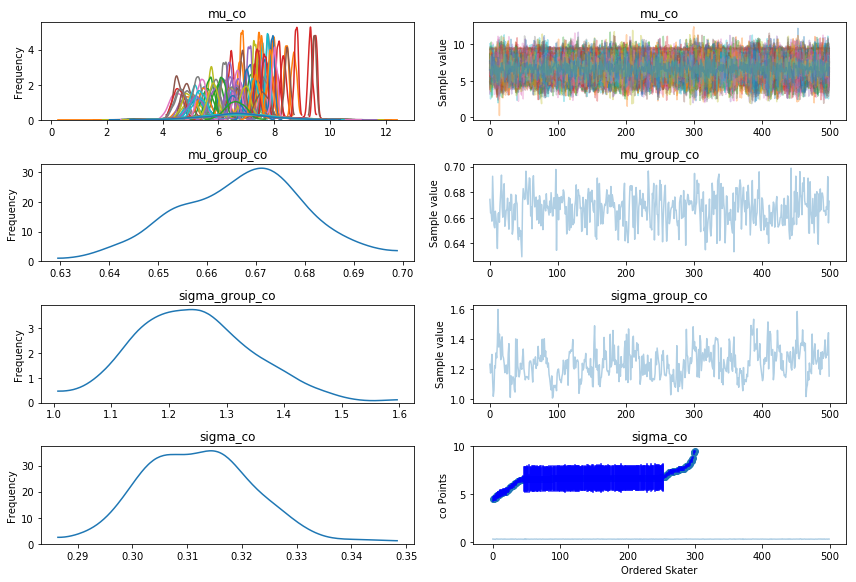

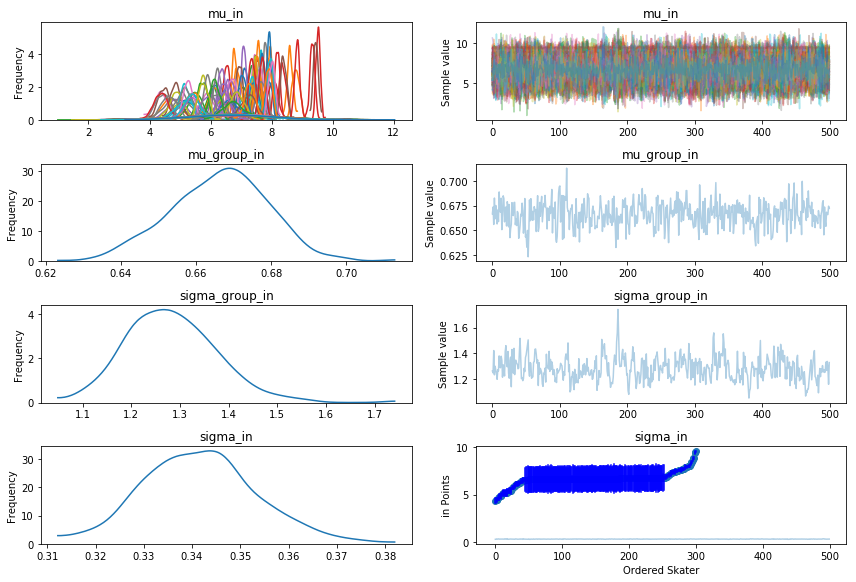

In [23]:
for comp_type in COMP_TYPES:
    comps = components[components.comp_type == comp_type]
    skater = comps['skater_code'] = comps.skater.replace(skater_lookup).values
    skater = theano.shared(skater)
    points = comps.points
    
    model = pm.Model()
    with model:
        # Prior on group distribution.
        mu_g = pm.Beta('mu_group_' + comp_type, alpha=20, beta=7)
        sigma_g = pm.HalfCauchy('sigma_group_' + comp_type, 5)
        
        # Group distribution.
        mu = pm.Normal('mu_' + comp_type, mu=mu_g*10, sd=sigma_g, shape=num_skaters)
        sigma = pm.HalfCauchy('sigma_' + comp_type, 5)
        
        # Data model.
        y = pm.Normal('y_' + comp_type, mu[skater], sd=sigma, observed=points)

    # Fit the model.
    with model:
        trace = pm.sample()
        
    # Save the results.
    results[comp_type] = (trace, model, skater)
    
    # Visualize fit.
    pm.traceplot(trace)
    estimates = pd.Series(trace['mu_' + comp_type].mean(axis=0), index=skaters)
    se = pd.Series(trace['mu_' + comp_type].std(axis=0), index=skaters)
    order = estimates.sort_values().index
    plt.scatter(xrange(len(estimates)), estimates[order])
    for i, m, s in zip(range(len(estimates)), estimates[order], se[order]):
        plt.plot([i,i], [m-s, m+s], 'b-')
    plt.ylabel(comp_type + ' Points');plt.xlabel('Ordered Skater');

In [26]:
results['in'][0][-1]

{'mu_group_in': 0.67209899887240254,
 'mu_group_in_logodds__': 0.7176939124281948,
 'mu_in': array([ 7.76822732,  8.52749137,  7.71617179,  4.86455617,  7.25844704,
         9.07692133,  6.18166395,  8.08067589,  7.42971431,  5.25103484,
         7.24595608,  4.7740239 ,  7.24648922,  7.6618838 ,  6.04451341,
         7.31730163,  7.38417776,  4.76021864,  6.31587981,  6.46149111,
         6.72337496,  8.45830867,  5.90118412,  7.40267787,  6.09650269,
         7.82747192,  5.56743642,  5.87456846,  7.2605234 ,  5.00994598,
         8.60119713,  3.85609044,  7.0084922 ,  6.17232359,  6.96915923,
         7.01877559,  7.3160781 ,  7.79667663,  6.13773029,  5.91882507,
         5.91063571,  6.79053178,  5.05172139,  7.28931151,  7.24841875,
         8.71044232,  7.58360994,  9.34087599,  5.94705275,  5.88425519,
         4.16564476,  6.23615221,  3.85660629,  7.81470212,  8.06392875,
         6.08823399,  5.5801858 ,  7.54275095,  5.50222966,  4.32953535,
         5.27162781,  6.40336432

In [27]:
elements18 = pd.read_csv('pd_data/elements18_men.csv')
components18 = pd.read_csv('pd_data/components_summary18_men.csv')

In [29]:
new_skater = len(skater_lookup)

In [114]:
elements18['skater_code'] = elements18.apply(lambda row: skater_lookup.get(row.skater, -1), axis=1)
components18['skater_code'] = components18.apply(lambda row: skater_lookup.get(row.skater, -1), axis=1)

In [100]:
ppc = {}
means = {}

100%|██████████| 500/500 [00:00<00:00, 1505.82it/s]


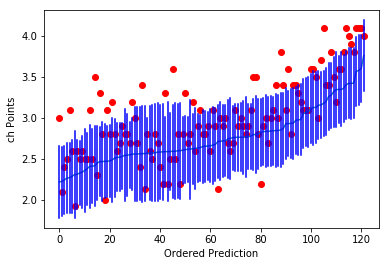

100%|██████████| 500/500 [00:00<00:00, 993.86it/s] 


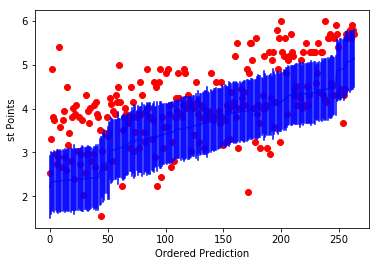

100%|██████████| 500/500 [00:00<00:00, 1496.80it/s]


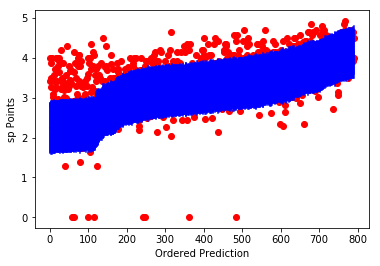

100%|██████████| 500/500 [00:00<00:00, 2041.16it/s]


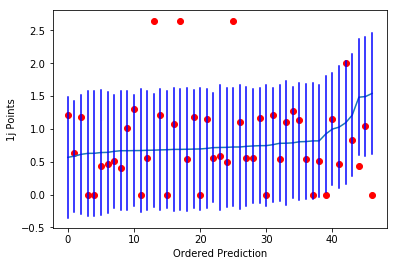

100%|██████████| 500/500 [00:00<00:00, 1670.17it/s]


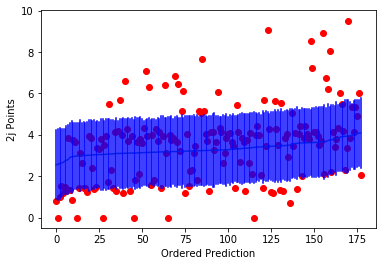

100%|██████████| 500/500 [00:00<00:00, 1496.25it/s]


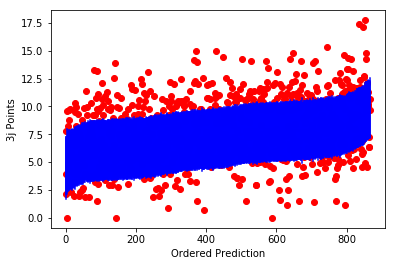

100%|██████████| 500/500 [00:00<00:00, 1456.13it/s]


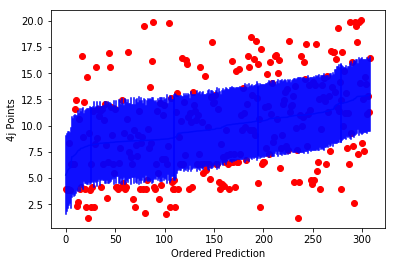

In [136]:
for elt_type in ELT_TYPES:
    with results[elt_type][1]:
        results[elt_type][2].set_value(np.asarray(elements18[elements18.elt_type == elt_type].skater_code))
        ppc[elt_type] = pm.sample_ppc(results[elt_type][0], model=results[elt_type][1], samples=500)['y_' + elt_type]

    mean = means[elt_type] = ppc[elt_type].mean(axis=0)
    std = np.std(ppc[elt_type], axis=0)
    real_outcomes = elements18[elements18.elt_type == elt_type]
    order = pd.Series(mean).sort_values().index
    outcomes = []
    for index in order:
        outcomes.append(real_outcomes.iloc[index].points)
    plt.scatter(xrange(len(mean)), outcomes, color='r')
    plt.plot(xrange(len(mean)), [mean[x] for x in order])
    for i, m, s in zip(xrange(len(mean)), mean[order], std[order]):
        plt.plot([i,i], [m-s, m+s], 'b-')
    plt.ylabel(elt_type + ' Points');plt.xlabel('Ordered Prediction');
    plt.show()

100%|██████████| 500/500 [00:00<00:00, 2008.50it/s]


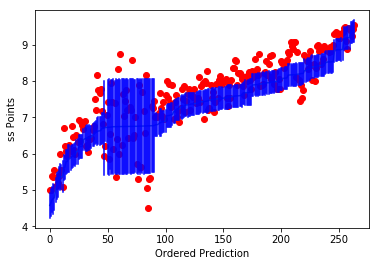

100%|██████████| 500/500 [00:00<00:00, 1430.43it/s]


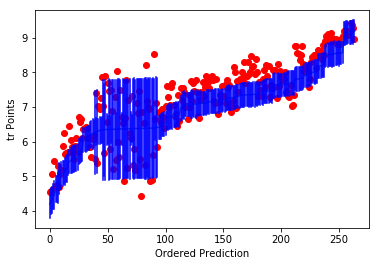

100%|██████████| 500/500 [00:00<00:00, 1911.87it/s]


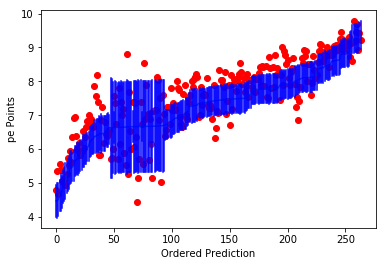

100%|██████████| 500/500 [00:00<00:00, 1855.33it/s]


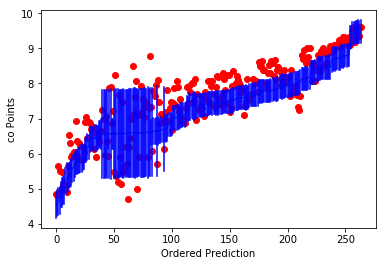

100%|██████████| 500/500 [00:00<00:00, 1936.96it/s]


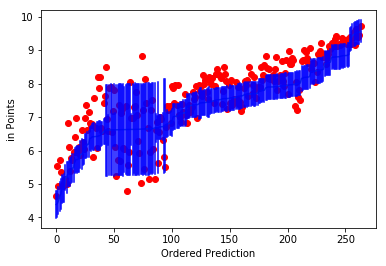

In [138]:
for comp_type in COMP_TYPES:
    with results[comp_type][1]:
        results[comp_type][2].set_value(np.asarray(components18[components18.comp_type == comp_type].skater_code))
        ppc[comp_type] = pm.sample_ppc(results[comp_type][0], model=results[comp_type][1], samples=500)['y_' + comp_type]
    
    mean = means[comp_type] = ppc[comp_type].mean(axis=0)
    std = np.std(ppc[comp_type], axis=0)
    
    # Sort actual point outcomes by order predicted by model.
    real_outcomes = components18[components18.comp_type == comp_type]
    order = pd.Series(mean).sort_values().index
    outcomes = []
    for index in order:
        outcomes.append(real_outcomes.iloc[index].points)
    plt.scatter(xrange(len(mean)), outcomes, color='r')
    plt.plot(xrange(len(mean)), [mean[x] for x in order])
    for i, m, s in zip(xrange(len(mean)), mean[order], std[order]):
        plt.plot([i,i], [m-s, m+s], 'b-')
    plt.ylabel(comp_type + ' Points');plt.xlabel('Ordered Prediction');
    plt.show()

In [164]:
elt_predictions = elements18[['segment', 'event', 'element', 'elt_type', 'points', 'skater', 'skater_code']].copy()
comp_predictions = components18[['comp_type', 'event', 'segment', 'points', 'skater', 'skater_code']].copy()

In [165]:
elt_pred_col = []
elt_indices = {elt_type: 0 for elt_type in ELT_TYPES}
for index, row in elt_predictions.iterrows():
    elt_pred_col.append(means[row.elt_type][elt_indices[row.elt_type]])
    elt_indices[row.elt_type] += 1

In [166]:
comp_pred_col = []
comp_indices = {comp_type: 0 for comp_type in COMP_TYPES}
for index, row in comp_predictions.iterrows():
    comp_pred_col.append(means[row.comp_type][comp_indices[row.comp_type]])
    comp_indices[row.comp_type] += 1

In [167]:
elt_predictions['prediction'] = elt_pred_col
comp_predictions['prediction'] = comp_pred_col
comp_predictions.rename(columns={'comp_type': 'elt_type'}, inplace=True)
elt_predictions['is_elt'] = pd.Series([1] * len(elt_pred_col))
comp_predictions['is_elt'] = pd.Series([0] * len(comp_pred_col))

In [168]:
predictions = pd.concat([elt_predictions, comp_predictions])

In [169]:
predictions.to_csv('fits/men_predictions2.csv')

In [170]:
'Daniel SAMOHIN' in skater_lookup

True